In [16]:
import os
from collections import Counter
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Read data

In [2]:
DATA_PATH='data/raw/'
files=[fl for fl in os.listdir(DATA_PATH) if fl.endswith('.txt')]

txt=''
for fl in files:
    txt_=Path(DATA_PATH+fl).read_text().lower()
    
    txt_=txt_.replace('\n', '').replace('.', ' ').replace(',', ' ').replace('!', ' ').\
    replace('?', ' ').replace(':', ' ').replace(';', ' ').replace('™', ' ').replace('¶', ' ').\
    replace('(', ' ').replace(')', ' ').replace(']', ' ').replace('[', ' ').replace('„', ' ').\
    replace('“', ' ').replace('•', ' ').replace('¼', ' ').replace('¤', ' ')
    txt=f'{txt} {txt_}'

In [3]:
txt[:10]

' see oli l'

## Count char freq

In [4]:
cnt=Counter(txt.split())
len(cnt)

3572

In [8]:
df_cnt=pd.DataFrame(cnt.most_common(len(cnt)))
df_cnt.columns=['token', 'count']
df_cnt['prob']=np.divide(df_cnt['count'], df_cnt['count'].sum())
df_cnt['count_log']=np.log(df_cnt['count'])
df_cnt['prob_log']=np.log(df_cnt['prob'])
df_cnt.head()

,token,count,prob,count_log,prob_log
0,ã,452,0.037573,6.113682,-3.281477
1,ja,310,0.025769,5.736572,-3.658587
2,ta,192,0.015960,5.257495,-4.137663
3,kã,185,0.015378,5.220356,-4.174803
4,â€œ,156,0.012968,5.049856,-4.345303


<AxesSubplot:>

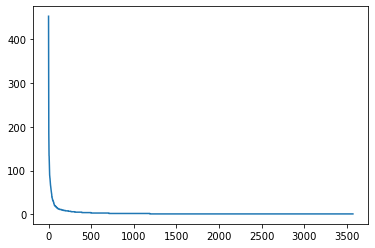

In [9]:
df_cnt['count'].plot()

<AxesSubplot:>

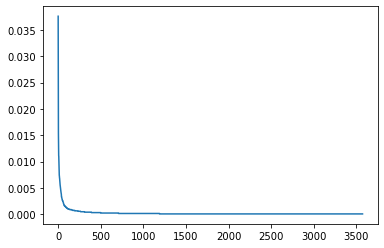

In [10]:
df_cnt['prob'].plot()

<AxesSubplot:>

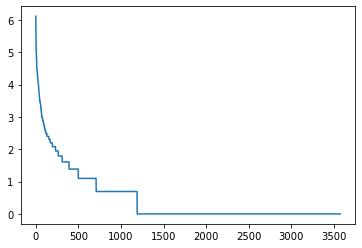

In [11]:
df_cnt['count_log'].plot()

<AxesSubplot:>

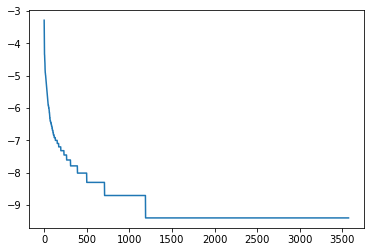

In [12]:
df_cnt['prob_log'].plot()

<AxesSubplot:xlabel='count_log', ylabel='prob_log'>

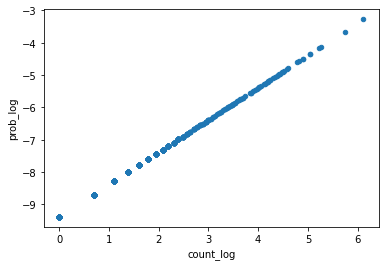

In [14]:
df_cnt.plot.scatter('count_log','prob_log')

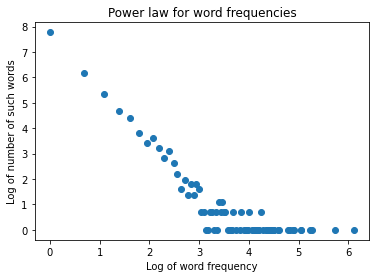

In [17]:
counter_of_words = Counter(txt.split())
counter_of_counts = Counter(counter_of_words.values())
word_counts = np.array(list(counter_of_counts.keys()))
freq_of_word_counts = np.array(list(counter_of_counts.values()))
plt.scatter(np.log(word_counts), np.log(freq_of_word_counts))
plt.xlabel('Log of word frequency')
plt.ylabel('Log of number of such words')
plt.title('Power law for word frequencies')
plt.show();

In [19]:
counter_of_counts

Counter({77: 1,
         155: 1,
         83: 1,
         18: 4,
         1: 2383,
         91: 1,
         6: 46,
         3: 209,
         120: 1,
         12: 14,
         125: 1,
         79: 1,
         8: 37,
         31: 2,
         4: 109,
         2: 481,
         26: 2,
         58: 1,
         10: 17,
         11: 22,
         49: 1,
         89: 1,
         39: 1,
         5: 81,
         310: 1,
         192: 1,
         47: 2,
         55: 2,
         156: 1,
         32: 3,
         185: 1,
         452: 1,
         25: 2,
         9: 25,
         88: 1,
         84: 1,
         34: 2,
         16: 4,
         67: 1,
         133: 1,
         19: 6,
         99: 1,
         69: 2,
         7: 31,
         38: 1,
         22: 2,
         30: 3,
         42: 1,
         14: 5,
         15: 7,
         98: 1,
         82: 1,
         40: 2,
         73: 1,
         51: 1,
         134: 1,
         46: 1,
         37: 1,
         36: 1,
         20: 5,
         17: 6,
      